In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import *; from tools.BLtools import *; from tools.e5tools import *
from tropicalOrographicRegions.mountainUtils import tilted_rect

from scipy.stats import linregress
#xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [1]:
import dask
from dask.distributed import Client, LocalCluster
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{host}:{port}/status"
client = Client(n_workers=8,threads_per_worker=1)#,memory_limit='20G')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,Workers: 8
Total threads: 8,Total memory: 503.14 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44459,Workers: 8
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 503.14 GiB
Comm: tcp://127.0.0.1:44089,Total threads: 1
Dashboard: /user/qnicolas/perlmutter-login-node-base/proxy/127.0.0.1:43415/status,Memory: 62.89 GiB
Nanny: tcp://127.0.0.1:39127,


In [3]:
from tools.wrfHrTools import Simulation,change_coords_pl,change_coords_sfc

In [10]:
class SimulationCustom2(Simulation):
    def __init__(self,path,center,dx,suffix,suffix2,inp=False,out=False,pout=False,is_subset=False,typ=1,onlypbl=False):
        super().__init__(path,center,dx,inp,out,pout,is_subset)
        self.suffix2 = suffix2
        if not onlypbl:
            self.RAINNC_MEAN = xr.open_dataarray(self.path+'wrf.RAINNC.ALLMEAN.nc')
            #RAINNC_DAILY = xr.open_zarr(self.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY[1200:].mean('south_north').coarsen(Time=24).mean()
            #self.RAINNC_STERR = 2 * RAINNC_DAILY.std('Time').load() / np.sqrt(len(RAINNC_DAILY.Time))
            
            self.W_PL_MEAN = xr.open_dataarray(self.path+'wrf.W_PL.ALLMEAN.nc')
            self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
            self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
            self.T_PL_SHORTMEAN = xr.open_dataarray(self.path+'wrf.T_PL.SHORTMEAN.nc')
            self.Q_PL_SHORTMEAN = xr.open_dataarray(self.path+'wrf.Q_PL.SHORTMEAN.nc')
            self.TL_TIMESERIES      = xr.open_zarr(self.path +'wrf.TL.TIMESERIES_TEST.zarr').T_PL  
            self.QL_TIMESERIES      = xr.open_zarr(self.path +'wrf.QL.TIMESERIES_TEST.zarr').Q_PL  

        if typ ==2:
            self.RAINNCV_HOURLY     = xr.open_zarr(self.path +'diags/wrf.RAINNCV_HOURLY.%s.zarr'%suffix).RAINNCV
            self.RAINNC_HOURLY      = xr.open_zarr(self.path +'diags/wrf.RAINNC_HOURLY.%s.zarr'%suffix).RAINNC

        elif typ==1:
            self.RAINNCV_HOURLY     = xr.open_zarr(self.path +'wrf.SFCVARS.1h.%s.zarr'%suffix2).RAINNCV_MMDY
            self.RAINNC_HOURLY      = xr.open_zarr(self.path +'wrf.SFCVARS.1h.%s.zarr'%suffix2).RAINNC_MMDY
            
        self.BLDEEP_HOURLY      = xr.open_zarr(self.path +'wrf.BL_DEEP.1h.%s.zarr'%suffix2).B_L  
        self.BL_HOURLY      = xr.open_zarr(self.path +'wrf.BL_700_900.1h.%s.zarr'%suffix2).B_L  
        
W10S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'      ,1635,3,'','1970010100-1970072000',inp=True,typ=1)
W12S300   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/',1635,3,'days1-365','1970010100-1971010400',inp=True,typ=2)

W10S300n2   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new2.3km/',1635,3,'','1970010100-1972091700',inp=False,typ=1,onlypbl=True)
W12S300n   = SimulationCustom2('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km/'  ,1635,3,'','1970010100-1972071900',inp=False,typ=1,onlypbl=True)


#W10S300.T_PL_MEAN2 = xr.open_dataarray(W10S300.path+'wrf.T_PL.ALLMEAN.2.nc')
#W10S300.Q_PL_MEAN2 = xr.open_dataarray(W10S300.path+'wrf.Q_PL.ALLMEAN.2.nc')
        

/tmp/ipykernel_542198/1250215461.py:19: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  self.RAINNCV_HOURLY     = xr.open_zarr(self.path +'diags/wrf.RAINNCV_HOURLY.%s.zarr'%suffix).RAINNCV


In [11]:
W12S300.RAINNCV_HOURLY = change_coords_sfc(W12S300.RAINNCV_HOURLY)
W12S300.RAINNC_HOURLY = change_coords_sfc(W12S300.RAINNC_HOURLY)
W12S300.RAINNCV_HOURLY = W12S300.RAINNCV_HOURLY.chunk(Time=240,distance_from_mtn=100)

In [12]:
W10S300.color='c'
W12S300.color='blue'

W10S300n2.color='c'
W12S300n.color='blue'


W10S300.color2='limegreen'
W12S300.color2='darkgreen'

W10S300.color3='gold'
W12S300.color3='red'


W10S300.label=r'$U = 10$ m$\,$s$^{-1}$'
W12S300.label=r'$U = 12$ m$\,$s$^{-1}$'

In [13]:
def prime(ds):
    return ds - ds.sel(distance_from_mtn=slice(-2500,-4000)).mean('distance_from_mtn')

In [14]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile
xx,hx=topographic_profile('cos',A=500.)

# The problem

(-1100.0, 1100.0)

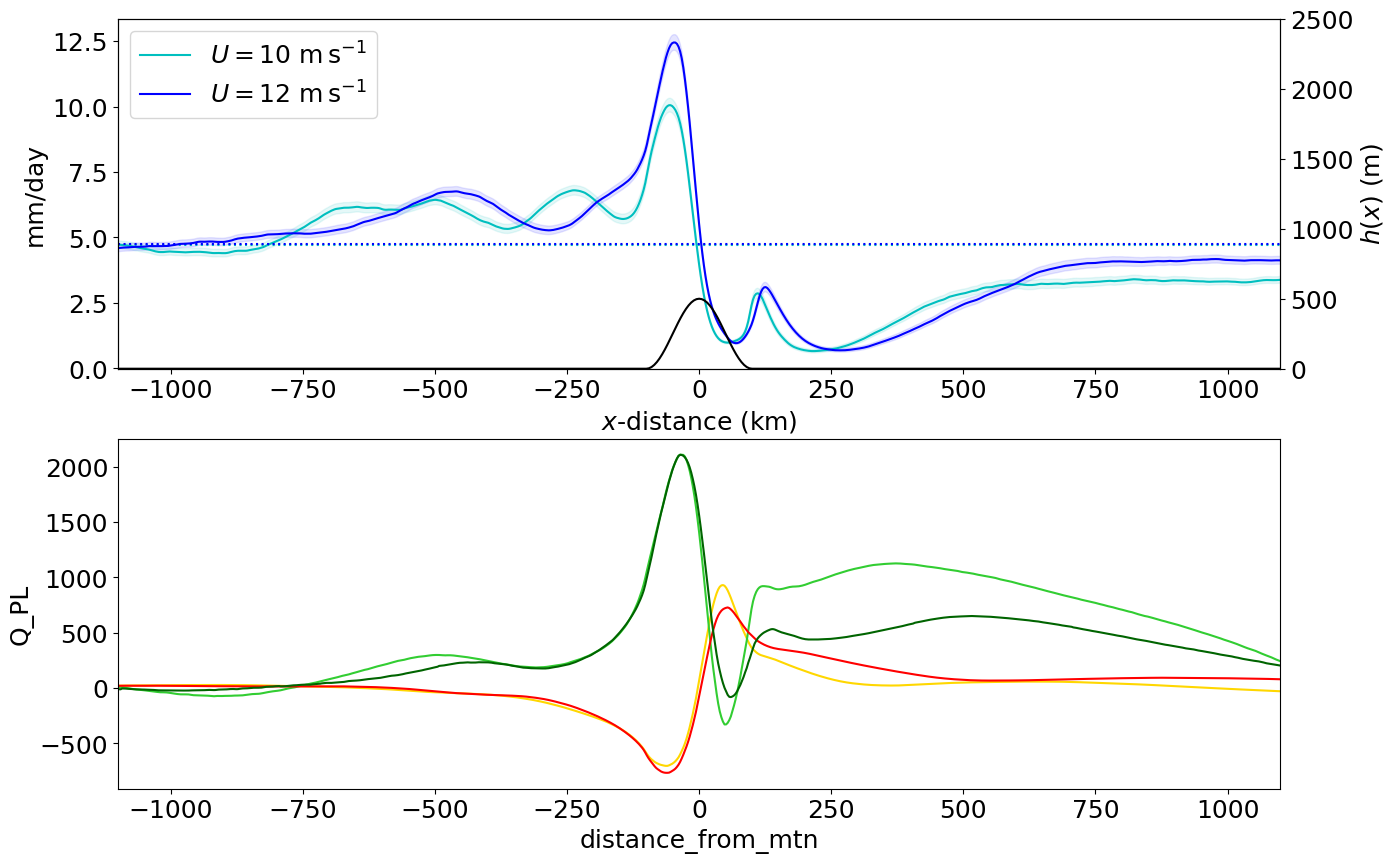

In [8]:
matplotlib.rcParams.update({'font.size':18})
fig,(ax,ax3) = plt.subplots(2,1,figsize=(15,10))

ax2 = ax.twinx()
ax2.plot(xx/1e3,hx,color='k')
ax2.set_ylim(0.,2500.)

for Sim in (W10S300,W12S300):
    Sim.RAINNC_MEAN.plot(ax=ax,color=Sim.color,label=Sim.label)
    ax.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,Sim.RAINNC_MEAN-Sim.RAINNC_STERR,Sim.RAINNC_MEAN+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)
    ax.axhline(Sim.RAINNC_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),color=Sim.color,linestyle=':')
    
    (-1004  * prime(Sim.T_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200).plot(ax=ax3,color=Sim.color3)
    (-2.5e6 * prime(Sim.Q_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200).plot(ax=ax3,color=Sim.color2)

    
    
ax2.set_ylabel(r"$h(x)$ (m)")
ax.set_ylabel("mm/day")
ax.set_xlabel(r'$x$-distance (km)')
ax.legend(loc=2)
ax.set_xlim(-1100,1100)
ax3.set_xlim(-1100,1100)


(-1100.0, 1100.0)

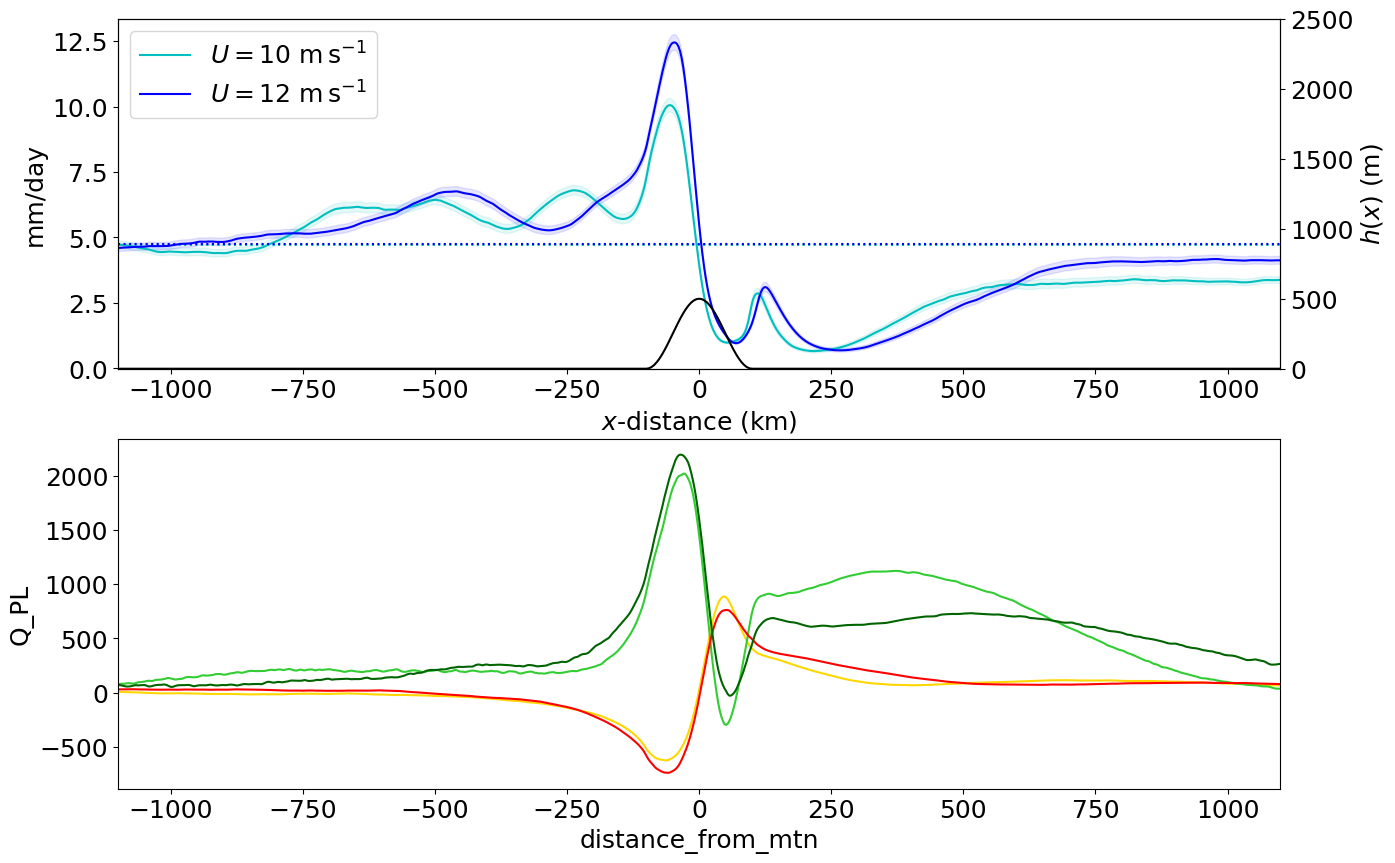

In [26]:
matplotlib.rcParams.update({'font.size':18})
fig,(ax,ax3) = plt.subplots(2,1,figsize=(15,10))

ax2 = ax.twinx()
ax2.plot(xx/1e3,hx,color='k')
ax2.set_ylim(0.,2500.)

for Sim in (W10S300,W12S300):
    Sim.RAINNC_MEAN.plot(ax=ax,color=Sim.color,label=Sim.label)
    ax.fill_between(Sim.RAINNC_MEAN.distance_from_mtn,Sim.RAINNC_MEAN-Sim.RAINNC_STERR,Sim.RAINNC_MEAN+Sim.RAINNC_STERR,alpha=0.1,color=Sim.color)
    ax.axhline(Sim.RAINNC_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),color=Sim.color,linestyle=':')
    
    (-1004  * prime(Sim.T_PL_SHORTMEAN).sel(pressure=slice(900,700)).integrate('pressure')/200).plot(ax=ax3,color=Sim.color3)
    (-2.5e6 * prime(Sim.Q_PL_SHORTMEAN).sel(pressure=slice(900,700)).integrate('pressure')/200).plot(ax=ax3,color=Sim.color2)

    
    
ax2.set_ylabel(r"$h(x)$ (m)")
ax.set_ylabel("mm/day")
ax.set_xlabel(r'$x$-distance (km)')
ax.legend(loc=2)
ax.set_xlim(-1100,1100)
ax3.set_xlim(-1100,1100)


(-1100.0, 1100.0)

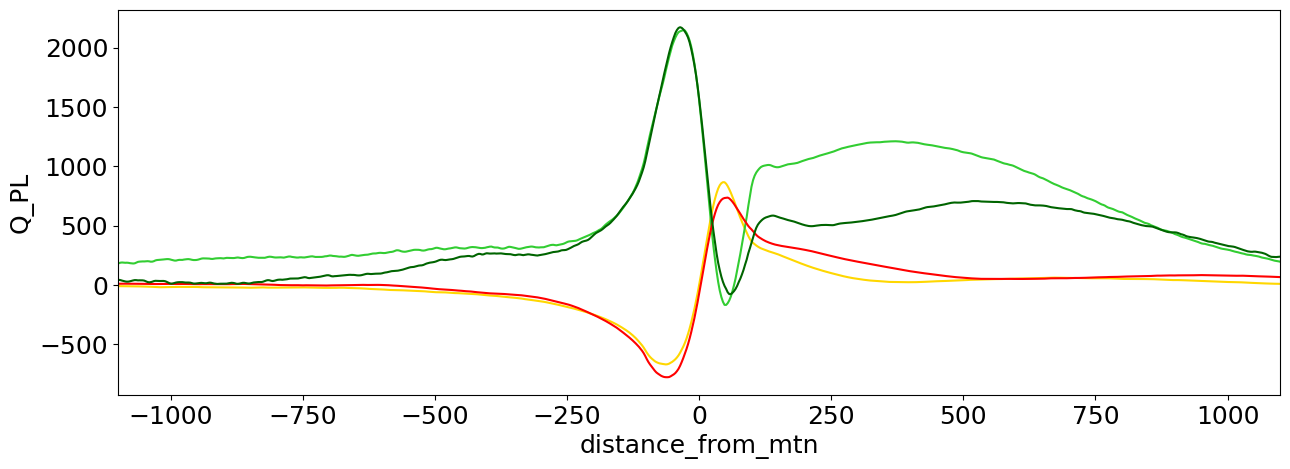

In [42]:
matplotlib.rcParams.update({'font.size':18})
fig,ax3 = plt.subplots(1,1,figsize=(15,5))

for Sim in (W10S300,W12S300):
    (1004  * prime(Sim.TL_TIMESERIES)[:3600//48]).mean('Time').plot(ax=ax3,color=Sim.color3)
    (2.5e6 * prime(Sim.QL_TIMESERIES)[:3600//48]).mean('Time').plot(ax=ax3,color=Sim.color2)


ax3.set_xlim(-1100,1100)


In [20]:
30000/48

625.0

(-1100.0, 1100.0)

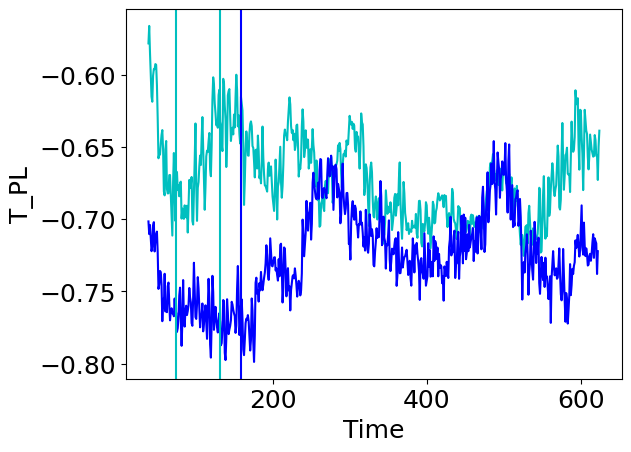

In [21]:
idx = prime(Sim.TL_TIMESERIES).mean('Time').argmin().data
for Sim in (W10S300,W12S300):
    prime(Sim.TL_TIMESERIES).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').rolling(Time=40).mean().plot(color=Sim.color)
#prime(Sim.QL_TIMESERIES).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').plot()

plt.axvline(3600//48,color='c')
plt.axvline((3600+2760)//48,color='c')
plt.axvline((8832-1200)//48,color='b')

ax3.set_xlim(-1100,1100)


(-1100.0, 1100.0)

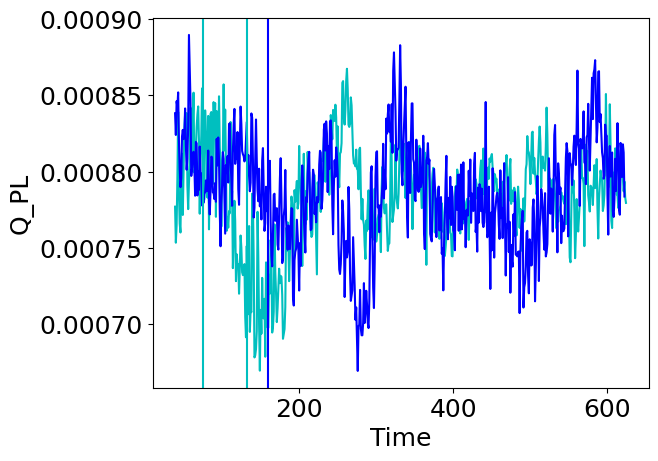

In [23]:
idx = prime(Sim.QL_TIMESERIES).mean('Time').argmax().data
for Sim in (W10S300,W12S300):
    prime(Sim.QL_TIMESERIES).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').rolling(Time=40).mean().plot(color=Sim.color)
#prime(Sim.QL_TIMESERIES).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').plot()

plt.axvline(3600//48,color='c')
plt.axvline((3600+2760)//48,color='c')
plt.axvline((8832-1200)//48,color='b')

ax3.set_xlim(-1100,1100)


In [36]:
W10S300.RAINNC_ALL = xr.open_zarr(W10S300.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY
W12S300.RAINNC_ALL = xr.open_zarr(W12S300.path+'wrf.RAINNC.1h.ALL_CONCAT.zarr').RAINNC_MMDY

(-1100.0, 1100.0)

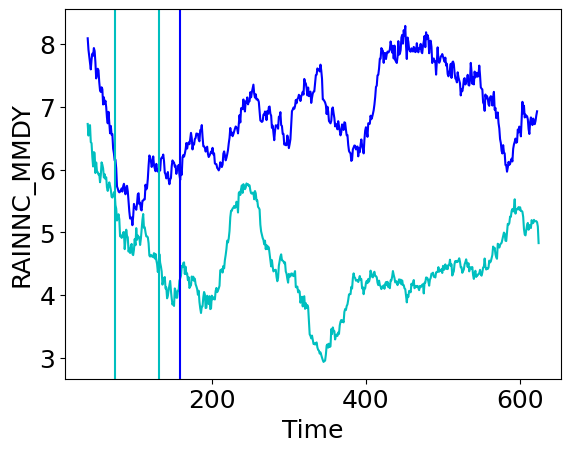

In [37]:
idx = int(prime(Sim.RAINNC_ALL.mean('south_north')).mean('Time').argmax().data)
for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_ALL.mean('south_north')).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').coarsen(Time=48,boundary='trim').mean().rolling(Time=40).mean().plot(color=Sim.color)
#prime(Sim.QL_TIMESERIES).isel(distance_from_mtn=slice(idx-10,idx+10)).mean('distance_from_mtn').plot()

plt.axvline(3600//48,color='c')
plt.axvline((3600+2760)//48,color='c')
plt.axvline((8832-1200)//48,color='b')

ax3.set_xlim(-1100,1100)


In [33]:
Sim = W10S300
tprime_10 = (-1004  * prime(Sim.T_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200)
qprime_10 = (-2.5e6 * prime(Sim.Q_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200)
Sim = W12S300
tprime_12 = (-1004  * prime(Sim.T_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200)
qprime_12 = (-2.5e6 * prime(Sim.Q_PL_MEAN).sel(pressure=slice(900,700)).integrate('pressure')/200)


In [38]:
((W12S300.RAINNC_MEAN.max()-4.5)/(W10S300.RAINNC_MEAN.max()-4.5)-1)/2*100

<xarray.DataArray 'RAINNC_MMDY' ()>
array(21.57931264)

In [34]:
(tprime_12.min()/tprime_10.min()-1)/2*100

<xarray.DataArray 'T_PL' ()>
array(4.44744825)

In [35]:
(qprime_12.max()/qprime_10.max()-1)/2*100

<xarray.DataArray 'Q_PL' ()>
array(-0.0369966)

# x-z profiles of w,t,q

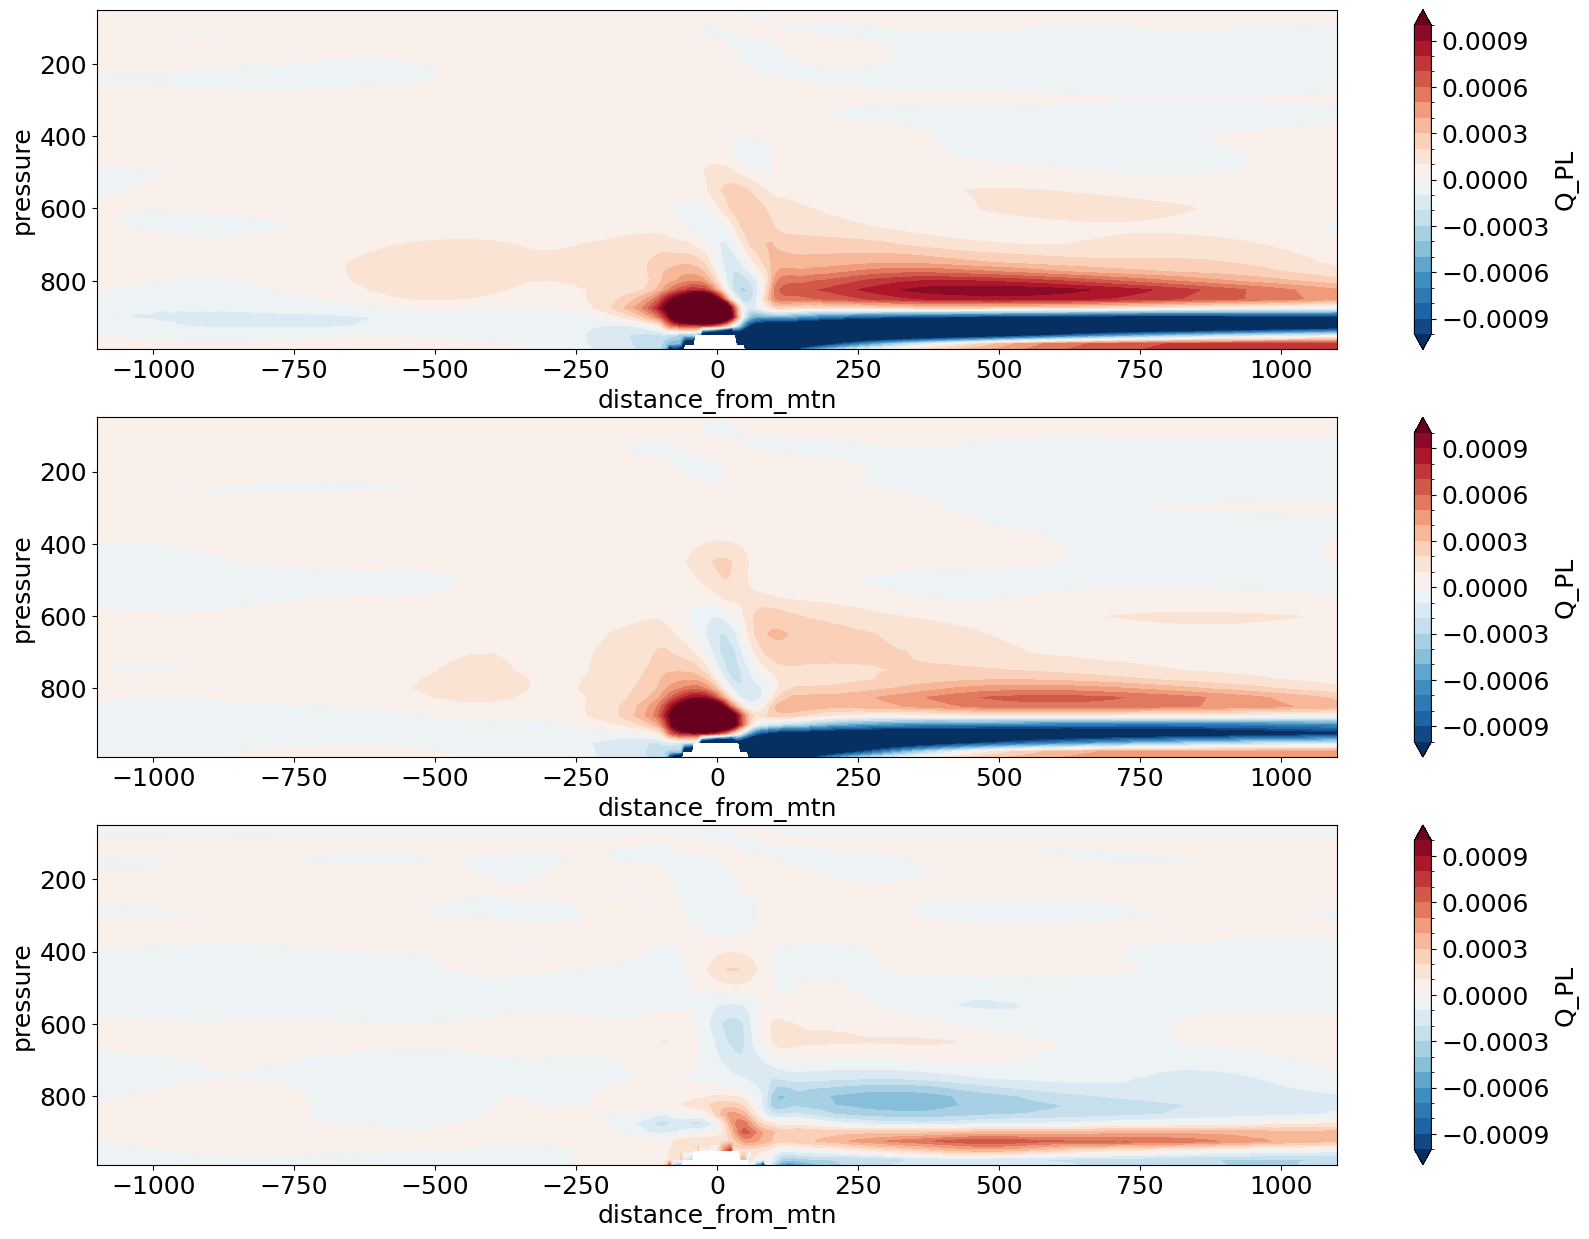

In [36]:
_,axs = plt.subplots(3,1,figsize=(20,15))
prime(W10S300.Q_PL_MEAN).plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=np.linspace(-0.001,0.001,21),extend='both')
prime(W12S300.Q_PL_MEAN).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=np.linspace(-0.001,0.001,21),extend='both')
(prime(W12S300.Q_PL_MEAN) - prime(W10S300.Q_PL_MEAN)).plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=np.linspace(-0.001,0.001,21),extend='both')
for ax in axs:
    ax.set_xlim(-1100,1100)
#plt.axhline(900)

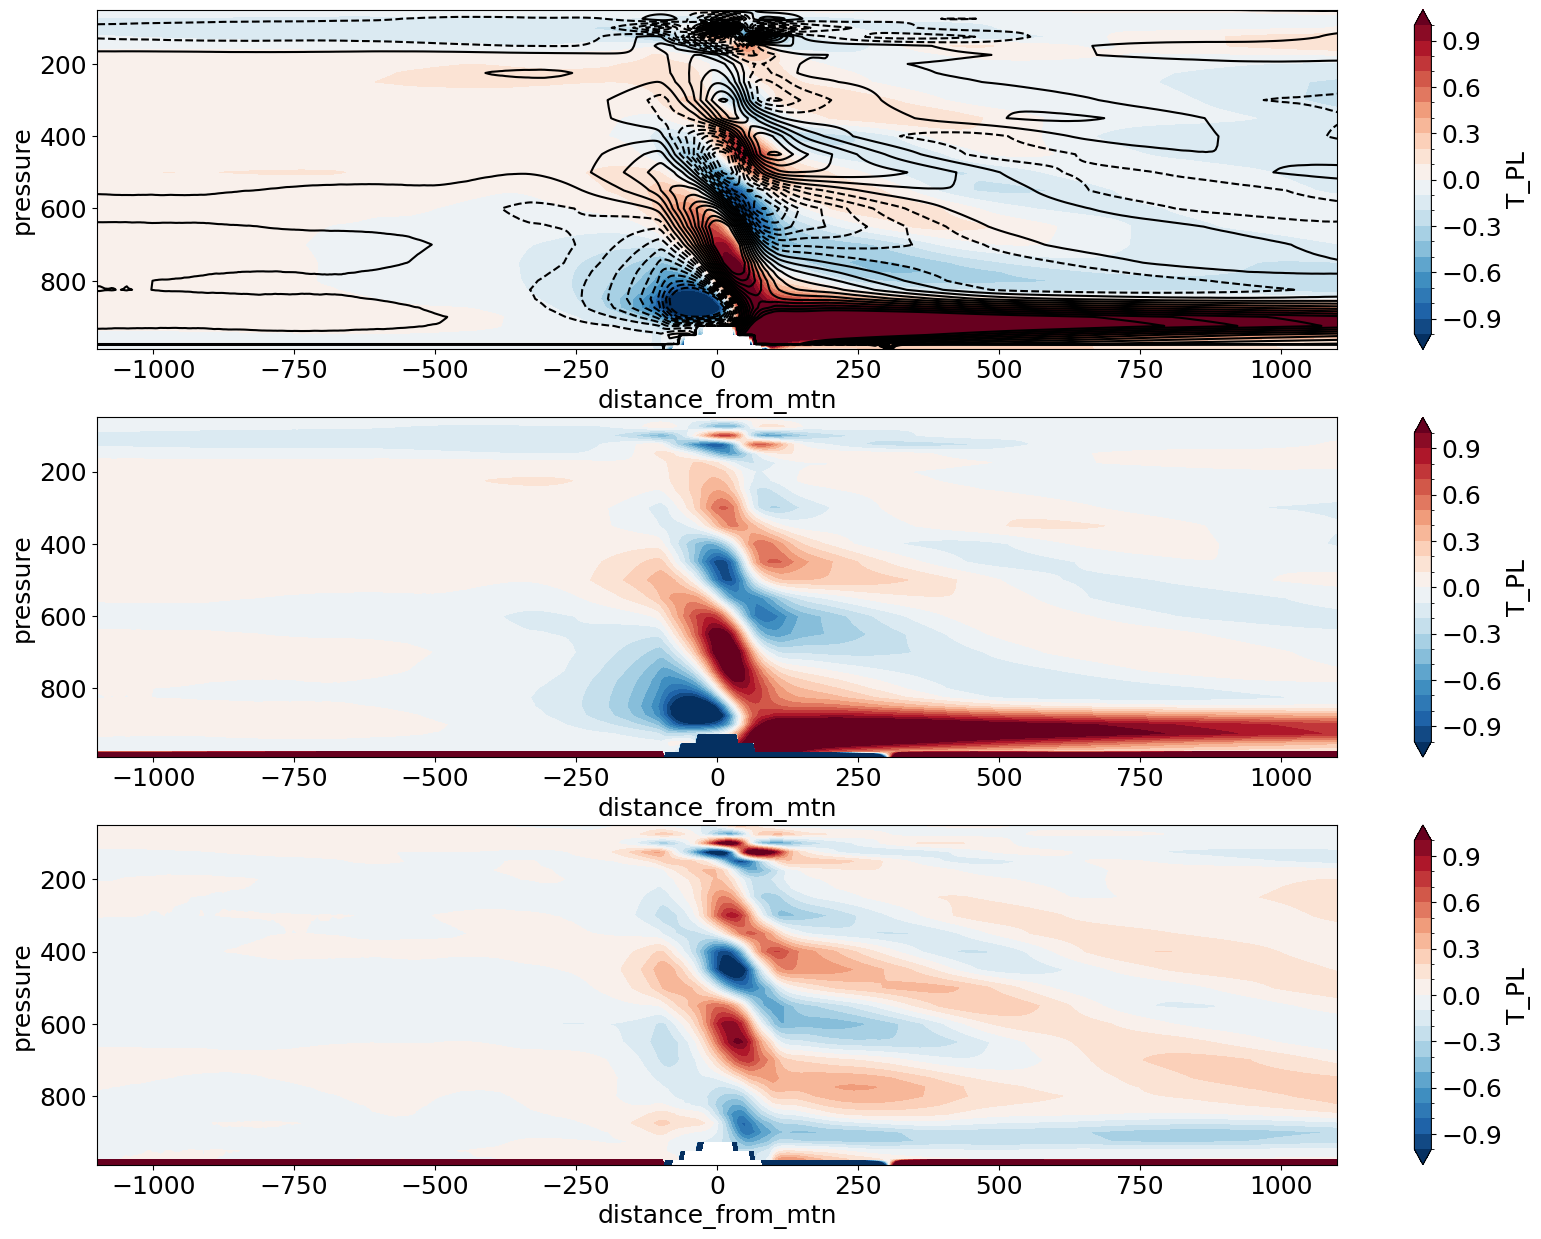

In [52]:
_,axs = plt.subplots(3,1,figsize=(20,15))
prime(W10S300.T_PL_MEAN).plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=np.linspace(-1.,1.,21),extend='both')
prime(W12S300.T_PL_MEAN).plot.contour(ax=axs[0],y='pressure',yincrease=False,levels=np.linspace(-1.,1.,21),colors='k')
prime(W12S300.T_PL_MEAN).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=np.linspace(-1.,1.,21),extend='both')
(prime(W12S300.T_PL_MEAN) - prime(W10S300.T_PL_MEAN)).plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=np.linspace(-1.,1.,21),extend='both')
for ax in axs:
    ax.set_xlim(-1100,1100)
#plt.axhline(900)

In [15]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

wlevs=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

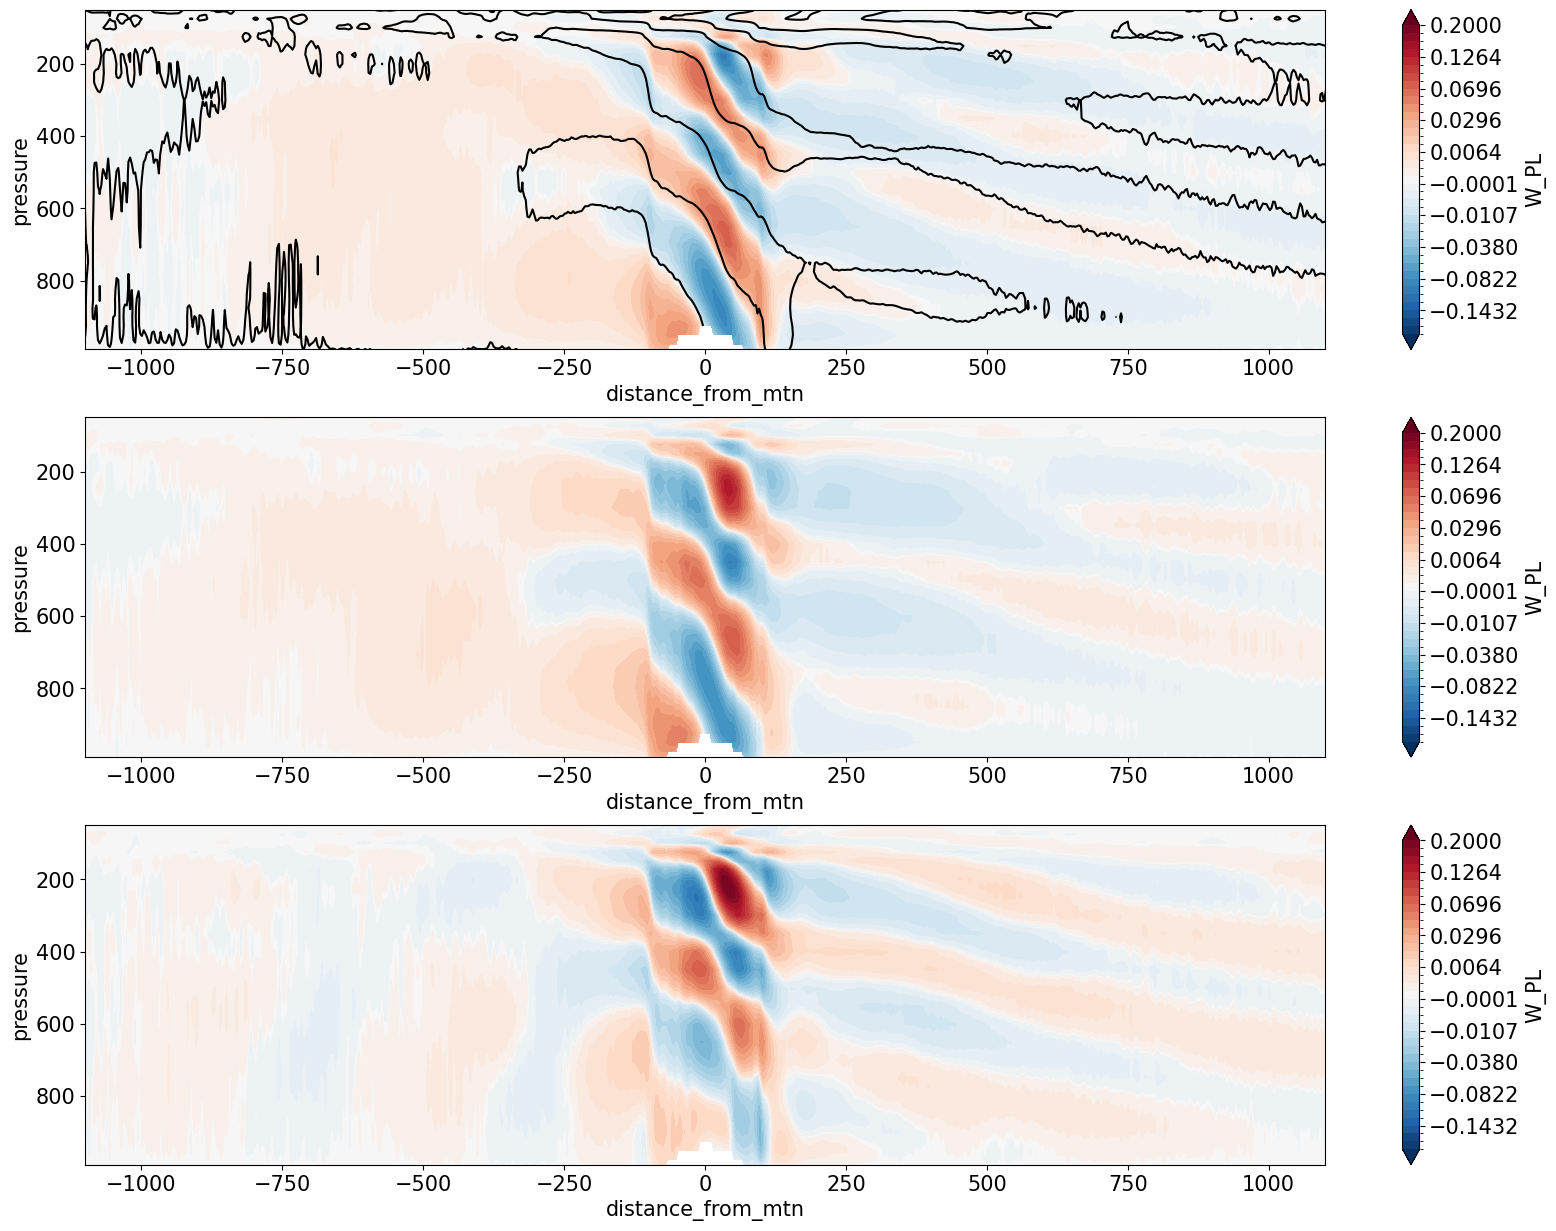

In [21]:
_,axs = plt.subplots(3,1,figsize=(20,15))
(W10S300.W_PL_MEAN).plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=wlevs,extend='both')
(W12S300.W_PL_MEAN).plot.contour (ax=axs[0],y='pressure',yincrease=False,levels=[0.],colors='k')
(W12S300.W_PL_MEAN).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=wlevs,extend='both')
((W12S300.W_PL_MEAN) - (W10S300.W_PL_MEAN)).plot.contourf(ax=axs[2],y='pressure',levels=wlevs,yincrease=False,extend='both')
for ax in axs:
    ax.set_xlim(-1100,1100)
#plt.axhline(900)

# Moisture budget

In [22]:
def integrate(y,x,x1,x2,y2):
    assert x[1]>=x[0]
    y1 = np.interp(x1,x,y)
    idxs = (x>x1)*(x<x2)*(~np.isnan(y))
    xi = np.concatenate(([x1],x[idxs],[x2]))
    yi = np.concatenate(([y1],y[idxs],[y2]))
    return np.trapz(yi,xi)

In [24]:
for Sim in W10S296,W10S300:
    Sim.Q2_MEAN = xr.open_dataarray(Sim.path+"wrf.Q2_INTERP.ALLMEAN.nc"  )
    Sim.U10_MEAN = xr.open_dataarray(Sim.path+"wrf.U10_INTERP.ALLMEAN.nc")
    Sim.PSFC_MEAN = xr.open_dataarray(Sim.path+'diags/wrf.PSFC.days150-200.nc').mean('south_north')

In [25]:
for Sim in W10S296,W10S300:
    Sim.Q_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.Q_PL.ALLMEAN.nc')
    #Sim.Q_PL_MEAN = Sim.Q_PL_MEAN.where(Sim.PSFC_MEAN/100-7>Sim.Q_PL_MEAN.pressure)
    Sim.U_PL_MEAN = xr.open_dataarray(Sim.path+'wrf.U_PL.ALLMEAN.nc')

In [22]:
test = xr.open_dataset("/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfout.T2_Q2_U10_PSFC.1970010100-1972072900mean.nc")
test.U10
test.Q2

evap = xr.open_dataarray("/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfout.EVAP_MMDY.1970010100-1972072900mean.nc")



In [38]:
for Sim in W10S296,W10S300:
    uq = (-Sim.U_PL_MEAN*Sim.Q_PL_MEAN)[::-1]
    uq_sfc = -Sim.Q2_MEAN*Sim.U10_MEAN
    uq_vinteg = xr.apply_ufunc(integrate,uq,uq.pressure,50,Sim.PSFC_MEAN/100,uq_sfc,input_core_dims=[['pressure'],['pressure'],[],[],[]],vectorize=True)*100/9.81
    uq_vinteg_smooth = xr.apply_ufunc(gaussian_filter1d,uq_vinteg,5)
    Sim.VIMC = -86400*uq_vinteg_smooth.differentiate('distance_from_mtn')/1000

# BL-precip relationship

In [15]:
def get_binned_dask(a,b,bins, return_counts=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    
    bin_sums = dask.array.histogram(a,bins,weights=b)[0]
    counts = dask.array.histogram(a,bins)[0]
    if return_counts:
        counts=counts.compute()
        return bin_centers,counts,bin_sums.compute()/counts
    else:
        return bin_centers,(bin_sums/counts).compute()

#def get_count_dask(a,bins,ntasks=16):
#    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
#    idx_bin_sup = np.argmin(bins<float(a.max()))
#    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
#        bins=bins[idx_bin_inf:]
#    else:
#        bins=bins[idx_bin_inf:idx_bin_sup+1]
#    bin_centers=(bins[1:]+bins[:-1])/2
#    
#    aa = dask.array.from_array(a, chunks=len(a)//ntasks+1)
#    count = dask.array.histogram(aa,bins)[0].compute()
#    return bin_centers,count


In [28]:
%%time
bins = np.linspace(-1,0.2,101)
for Sim in (W10S300,W12S300):
    centers,counts,means = get_binned_dask(Sim.BLDEEP_HOURLY[1200:4800].data.reshape(-1),Sim.RAINNCV_HOURLY[1200:4800].data.reshape(-1),bins,return_counts=True)
    Sim.BLbins = centers
    Sim.BLcounts = counts
    Sim.RAINNCV_HOURLY_BLbinned = means

    centers,counts,means = get_binned_dask(Sim.BLDEEP_HOURLY[1200:4800].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),Sim.RAINNCV_HOURLY[1200:4800].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),bins,return_counts=True)
    Sim.BLbins_mtn = centers
    Sim.BLcounts_mtn = counts
    Sim.RAINNCV_HOURLY_BLbinned_mtn = means


CPU times: user 18.3 s, sys: 3.54 s, total: 21.8 s
Wall time: 45.6 s


In [43]:
%%time
bins = np.linspace(-1,0.2,101)
for Sim in (W10S300,W12S300):
    centers,counts,means = get_binned_dask(Sim.BL_HOURLY[1200:4800].data.reshape(-1),Sim.RAINNCV_HOURLY[1200:4800].data.reshape(-1),bins,return_counts=True)
    Sim.BLSbins = centers
    Sim.BLScounts = counts
    Sim.RAINNCV_HOURLY_BLSbinned = means
    
    centers,counts,means = get_binned_dask(Sim.BL_HOURLY[1200:4800].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),Sim.RAINNCV_HOURLY[1200:4800].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),bins,return_counts=True)
    Sim.BLSbins_mtn = centers
    Sim.BLScounts_mtn = counts
    Sim.RAINNCV_HOURLY_BLSbinned_mtn = means


CPU times: user 38.2 s, sys: 6.56 s, total: 44.7 s
Wall time: 1min 35s


/tmp/ipykernel_157320/3707002253.py:14: RuntimeWarning: invalid value encountered in divide
  return bin_centers,counts,bin_sums.compute()/counts


In [ ]:
%%time
bins = np.linspace(-1,0.2,101)
for Sim in (W10S300n2,W12S300n):
    centers,counts,means = get_binned_dask(Sim.BL_HOURLY[1000:22000].data.reshape(-1),Sim.RAINNCV_HOURLY[1000:22000].data.reshape(-1),bins,return_counts=True)
    Sim.BLSbins = centers
    Sim.BLScounts = counts
    Sim.RAINNCV_HOURLY_BLSbinned = means
    
    centers,counts,means = get_binned_dask(Sim.BL_HOURLY[1000:22000].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),Sim.RAINNCV_HOURLY[1000:22000].sel(distance_from_mtn=slice(-20,-80)).data.reshape(-1),bins,return_counts=True)
    Sim.BLSbins_mtn = centers
    Sim.BLScounts_mtn = counts
    Sim.RAINNCV_HOURLY_BLSbinned_mtn = means


## deep

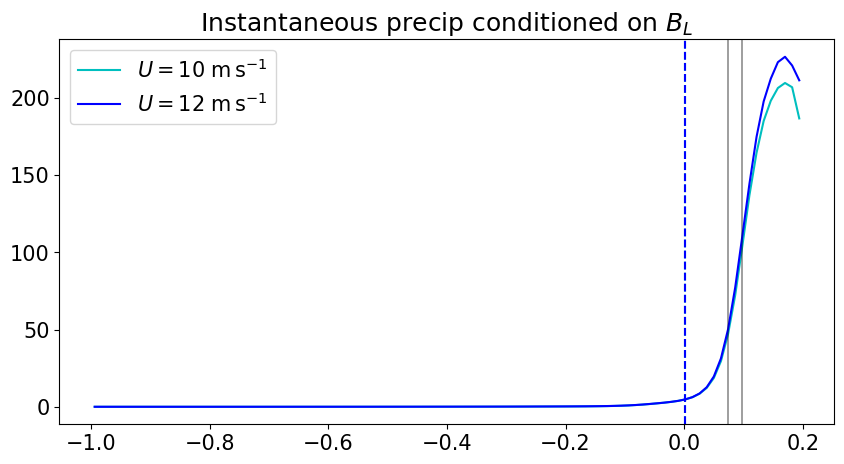

In [29]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300,W12S300):
    ax.plot(Sim.BLbins,Sim.RAINNCV_HOURLY_BLbinned,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLbins[np.argmax(Sim.BLcounts)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$')
ax.legend()


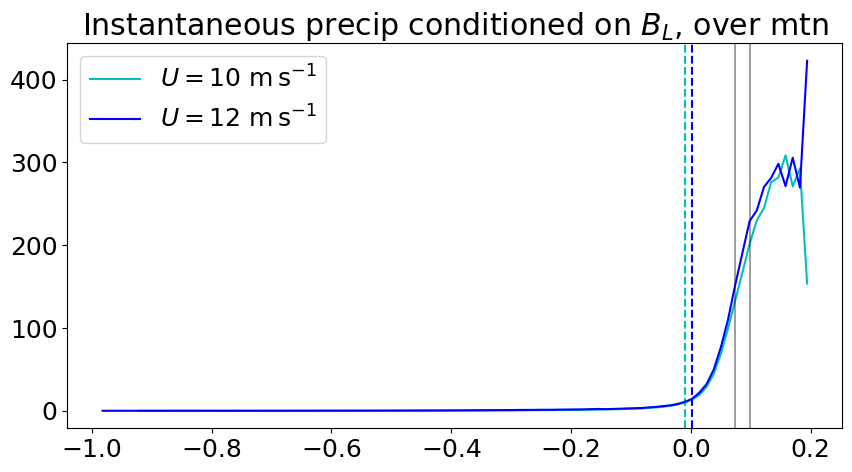

In [36]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300,W12S300):
    ax.plot(Sim.BLbins_mtn,Sim.RAINNCV_HOURLY_BLbinned_mtn,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLbins_mtn[np.argmax(Sim.BLcounts_mtn)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$, over mtn')
ax.legend()


CPU times: user 3.48 s, sys: 500 ms, total: 3.98 s
Wall time: 5.43 s


(-1500.0, 2000.0)

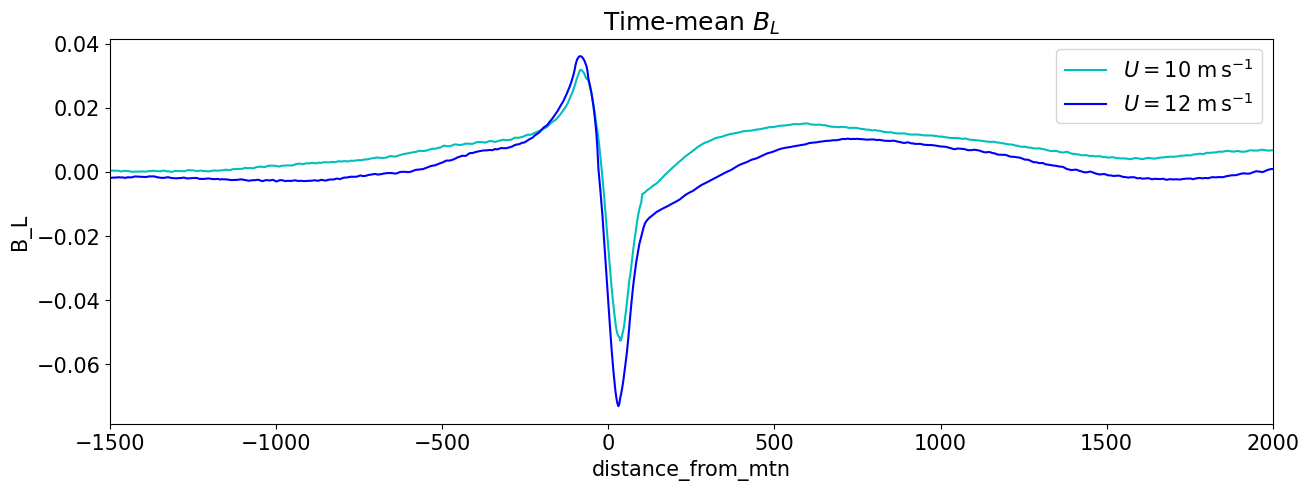

In [30]:
%%time
_,ax=plt.subplots(1,1,figsize=(15,5))
for Sim in (W10S300,W12S300):
    prime(Sim.BLDEEP_HOURLY[1200:4800].mean(('Time','south_north'))).plot(ax=ax,color=Sim.color,label=Sim.label)
ax.set_title(r'Time-mean $B_L$')
ax.legend()
ax.set_xlim(-1500,2000)

## shallow

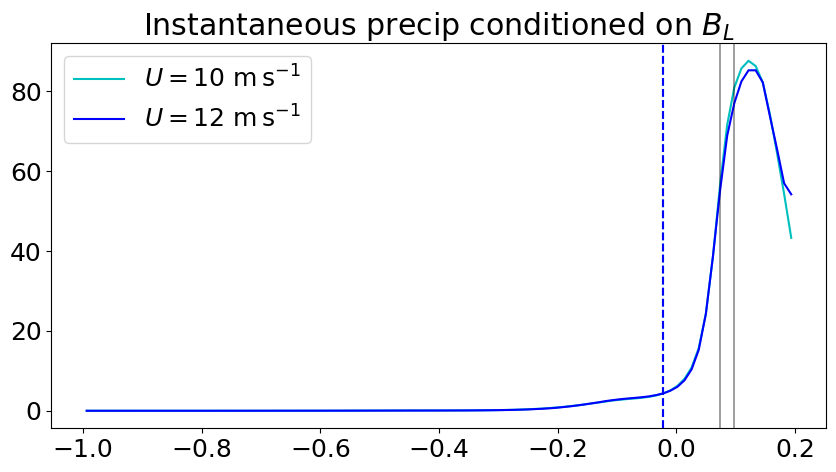

In [44]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300,W12S300):
    ax.plot(Sim.BLSbins,Sim.RAINNCV_HOURLY_BLSbinned,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLSbins[np.argmax(Sim.BLScounts)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$')
ax.legend()


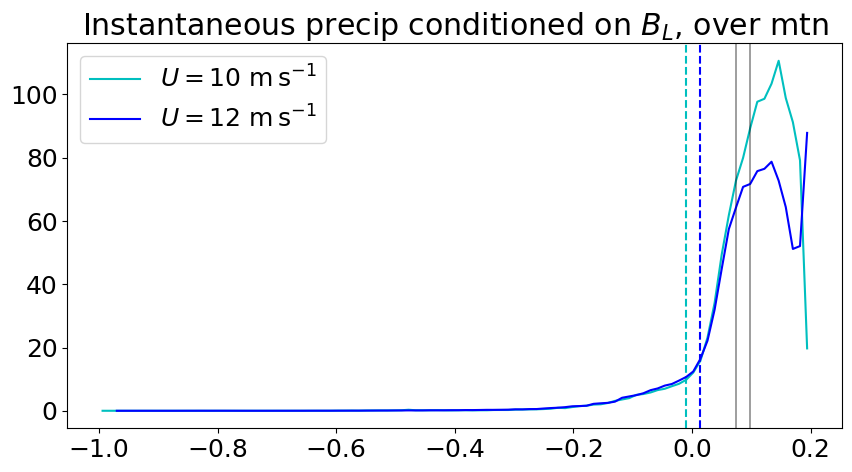

In [45]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300,W12S300):
    ax.plot(Sim.BLSbins_mtn,Sim.RAINNCV_HOURLY_BLSbinned_mtn,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLSbins_mtn[np.argmax(Sim.BLScounts_mtn)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$, over mtn')
ax.legend()


CPU times: user 3.15 s, sys: 754 ms, total: 3.9 s
Wall time: 8.51 s


(-1500.0, 2000.0)

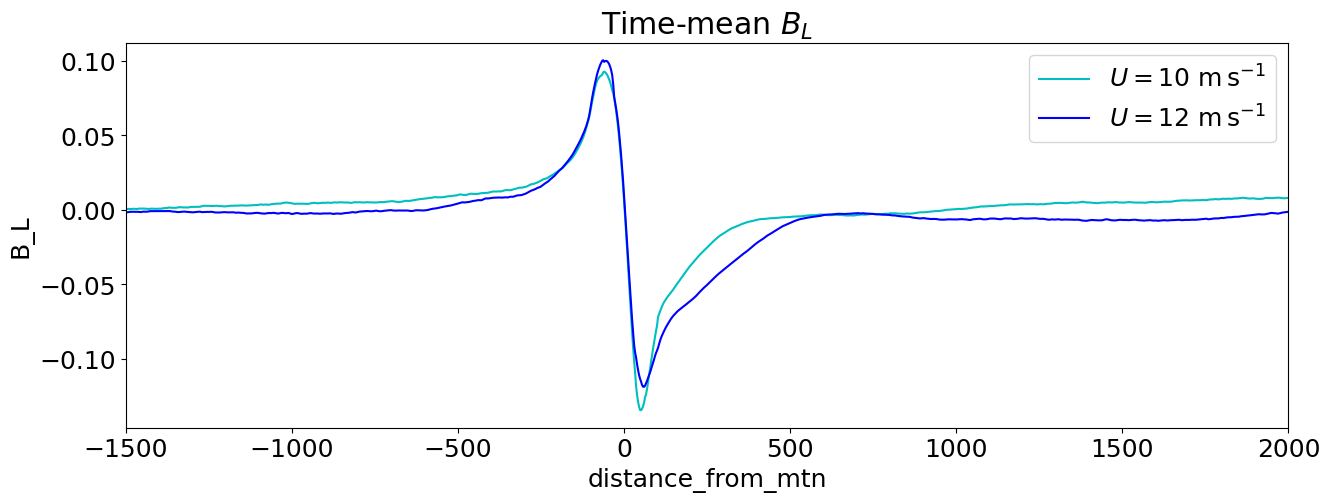

In [46]:
%%time
_,ax=plt.subplots(1,1,figsize=(15,5))
for Sim in (W10S300,W12S300):
    prime(Sim.BL_HOURLY[1200:4800].mean(('Time','south_north'))).plot(ax=ax,color=Sim.color,label=Sim.label)
ax.set_title(r'Time-mean $B_L$')
ax.legend()
ax.set_xlim(-1500,2000)

CPU times: user 2.73 s, sys: 351 ms, total: 3.08 s
Wall time: 4.26 s


(-1500.0, 2000.0)

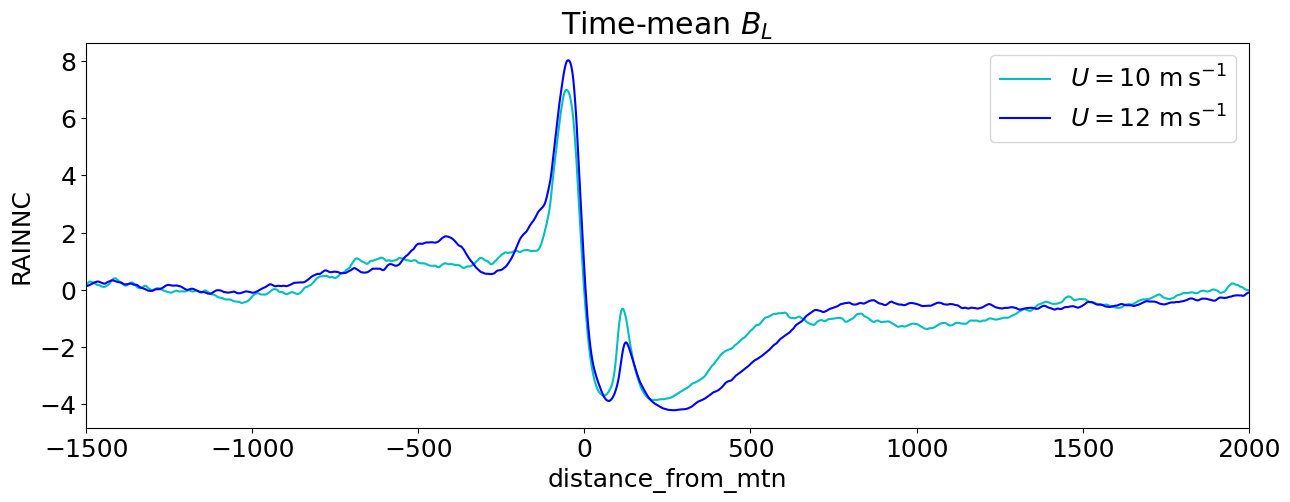

In [47]:
%%time
_,ax=plt.subplots(1,1,figsize=(15,5))
for Sim in (W10S300,W12S300):
    prime(Sim.RAINNC_HOURLY[1200:4800].mean(('Time','south_north'))).plot(ax=ax,color=Sim.color,label=Sim.label)
ax.set_title(r'Time-mean $B_L$')
ax.legend()
ax.set_xlim(-1500,2000)

In [53]:
BLmean_10 = prime(W10S300.BL_HOURLY[1200:4800].mean(('Time','south_north'))).load()
BLmean_12 = prime(W12S300.BL_HOURLY[1200:4800].mean(('Time','south_north'))).load()

In [54]:
idx = int(BLmean_12.argmax())

In [55]:
(BLmean_12[idx-3:idx+3].mean()/BLmean_10[idx-3:idx+3].mean()-1)/2*100

<xarray.DataArray 'B_L' ()>
array(4.42344527)
Coordinates:
    pressure  float32 990.0

In [56]:
BLmean_10 = prime(W10S300.RAINNC_HOURLY[1200:4800].mean(('Time','south_north'))).load()
BLmean_12 = prime(W12S300.RAINNC_HOURLY[1200:4800].mean(('Time','south_north'))).load()

In [59]:
idx = int(BLmean_12.argmax())

In [60]:
(BLmean_12[idx-3:idx+3].mean()/BLmean_10[idx-3:idx+3].mean()-1)/2*100

<xarray.DataArray ()>
array(8.32316875)

In [61]:
BLmean_10 = prime(W10S300.TL_TIMESERIES)[:3600//48].mean('Time')
BLmean_12 = prime(W12S300.TL_TIMESERIES)[:3600//48].mean('Time')

In [65]:
idx = int(BLmean_10.argmin())

In [66]:
(BLmean_12[idx-3:idx+3].mean()/BLmean_10[idx-3:idx+3].mean()-1).load()/2*100

<xarray.DataArray 'T_PL' ()>
array(8.24161172)

In [ ]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300n2,W12S300n):
    ax.plot(Sim.BLSbins,Sim.RAINNCV_HOURLY_BLSbinned,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLSbins[np.argmax(Sim.BLScounts)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$')
ax.legend()


In [ ]:
_,ax=plt.subplots(figsize=(10,5))
for Sim in (W10S300n2,W12S300n):
    ax.plot(Sim.BLSbins_mtn,Sim.RAINNCV_HOURLY_BLSbinned_mtn,label=Sim.label,color=Sim.color)
    ax.axvline(Sim.BLSbins_mtn[np.argmax(Sim.BLScounts_mtn)],color=Sim.color,linestyle='--')
    ax.axvline(0.098,linewidth=0.3,color='k')
    ax.axvline(0.074,linewidth=0.3,color='k')
ax.set_title(r'Instantaneous precip conditioned on $B_L$, over mtn')
ax.legend()
